In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import multimodal_vae
import torch_mvae_util as U
import util.RAVDESS_dataset_util as Rd
from train_mvae import build_model, train
from config_args import ConfigModelArgs, ConfigTrainArgs

In [3]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()

In [4]:
au_dataset = pd.read_csv(cfg_model.dataset_path).to_numpy()

In [5]:
au = au_dataset[:,:-1]
emotions = au_dataset[:,-1].astype(int)-1
au_dataset = [(x, y) for x, y in zip(au, emotions)]

In [6]:
trainingset_len = len(au_dataset) // 100 * 80
testset_len = len(au_dataset) - trainingset_len
training_dataset, testing_dataset = torch.utils.data.random_split(
    au_dataset, 
    [trainingset_len, testset_len],
    #generator=torch.Generator().manual_seed(66)
)

dataset_loader = DataLoader(training_dataset, batch_size=cfg_train.batch_size,
                        shuffle=False, num_workers=cfg_train.num_workers)

testset_loader = DataLoader(testing_dataset, batch_size=cfg_train.batch_size,
                        shuffle=False, num_workers=cfg_train.num_workers)

print('training set size: ',trainingset_len,'\ntest set size: ',testset_len)

training set size:  7920 
test set size:  1982


In [7]:
use_cuda = True

model_args = {
    'cat_dim' : cfg_model.cat_dim,
    'au_dim' : cfg_model.au_dim,
    'latent_space_dim' : cfg_model.z_dim,
    'hidden_dim' : cfg_model.hidden_dim,
    'num_filters' : cfg_model.num_filters,
    'modes' : cfg_model.modes,
    'au_weight': cfg_model.au_weight,
    'emotion_weight': cfg_model.emotion_weight,
    'expert_type' : cfg_model.expert_type,
    'use_cuda' : cfg_train.use_cuda
}
print(model_args)
train_args = {
    'learning_rate' : cfg_train.learning_rate,
    'optim_betas' : cfg_train.optim_betas,
    'num_epochs' : cfg_train.num_epochs,
    'batch_size' : cfg_train.batch_size
}
print(train_args)

{'cat_dim': 8, 'au_dim': 18, 'latent_space_dim': 50, 'hidden_dim': 512, 'num_filters': 32, 'modes': {'au': True, 'face': None, 'emotion': True}, 'au_weight': 10000.0, 'emotion_weight': 0.01, 'expert_type': 'poe', 'use_cuda': True}
{'learning_rate': 0.001, 'optim_betas': [0.95, 0.98], 'num_epochs': 30, 'batch_size': 256}


In [22]:
load_model = True

if load_model:    
    PATH = "../trained_models/best_train_moe.save"
    loaded_data = torch.load(PATH)
    model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
    model.load_state_dict(loaded_data['model_state'])
      
    model.eval()
else:
    model: torch.nn.Module = build_model(**model_args).double()

In [23]:
train_model = False

if train_model:
    training_losses = train(
        mvae_model=model,
        dataset_loader=dataset_loader,
        learning_rate=cfg_train.learning_rate,
        optim_betas=cfg_train.optim_betas,
        num_epochs=cfg_train.num_epochs,
        seed=cfg_train.seed,
        use_cuda=cfg_train.use_cuda,
        cfg=cfg_train,
        checkpoint_every=cfg_train.checkpoint_every,
        resume_train = False
    )

In [24]:
if train_model: U.print_losses(training_losses)

In [25]:
save_model = False

if save_model:
    PATH = "../trained_models/au_emo-poe.save"
    torch.save({'model_args' : model_args,
                'training_loss' : training_losses,
                'train_args': train_args,
                'model_params' : model.state_dict()
               }, PATH)

In [26]:
labels = list(Rd.emocat.values())

In [27]:
print('reg loss train: ' + str(U.au_to_au(model, dataset_loader).item()))
print('reg loss test: ' + str(U.au_to_au(model, testset_loader).item()))

reg loss train: 1.5436544385129107e-05
reg loss test: 1.5674212781250084e-05


100%|████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 118.41it/s]


              precision    recall  f1-score   support

     neutral       0.51      0.72      0.60       501
        calm       0.77      0.80      0.78      1091
       happy       0.83      0.84      0.83      1067
         sad       0.67      0.72      0.69      1054
       angry       0.68      0.56      0.62      1060
     fearful       0.68      0.66      0.67      1035
     disgust       0.79      0.84      0.81      1086
   surprised       0.66      0.52      0.58      1026

    accuracy                           0.71      7920
   macro avg       0.70      0.71      0.70      7920
weighted avg       0.71      0.71      0.71      7920



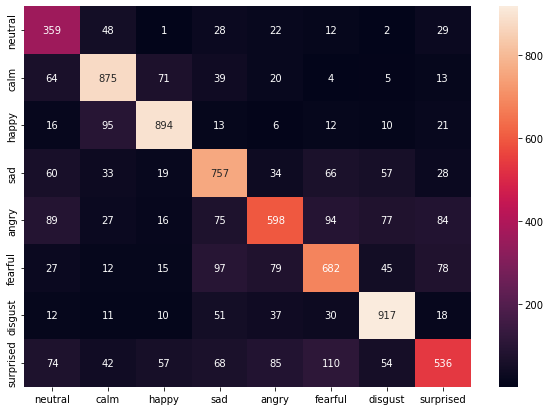

In [28]:
y_true, y_pred = U.au_classiffication_accuracy(model, dataset_loader)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)

100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 50.00it/s]


              precision    recall  f1-score   support

     neutral       0.58      0.73      0.65       144
        calm       0.76      0.83      0.79       242
       happy       0.88      0.86      0.87       257
         sad       0.64      0.71      0.67       275
       angry       0.66      0.59      0.62       278
     fearful       0.66      0.62      0.64       266
     disgust       0.74      0.82      0.78       257
   surprised       0.71      0.53      0.61       263

    accuracy                           0.71      1982
   macro avg       0.70      0.71      0.70      1982
weighted avg       0.71      0.71      0.71      1982



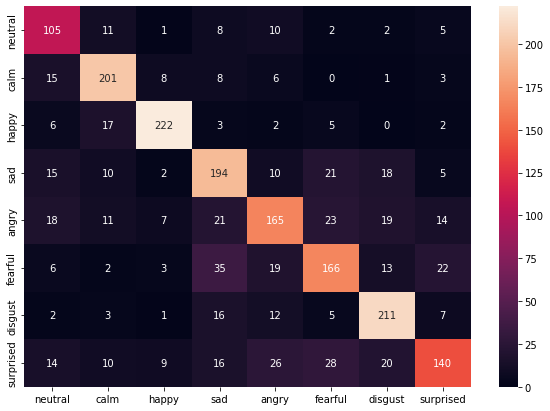

In [29]:
y_true, y_pred = U.au_classiffication_accuracy(model, testset_loader)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)

100%|████████████████████████████████████████████████████████████████| 2048/2048 [00:05<00:00, 365.70it/s]


              precision    recall  f1-score   support

     neutral       0.84      0.56      0.67      4168
        calm       0.46      0.66      0.54      4107
       happy       0.55      0.44      0.49      4078
         sad       0.19      0.41      0.26      4146
       angry       0.54      0.41      0.46      4045
     fearful       0.24      0.20      0.22      4099
     disgust       0.60      0.59      0.60      4020
   surprised       0.35      0.14      0.20      4105

    accuracy                           0.43     32768
   macro avg       0.47      0.43      0.43     32768
weighted avg       0.47      0.43      0.43     32768



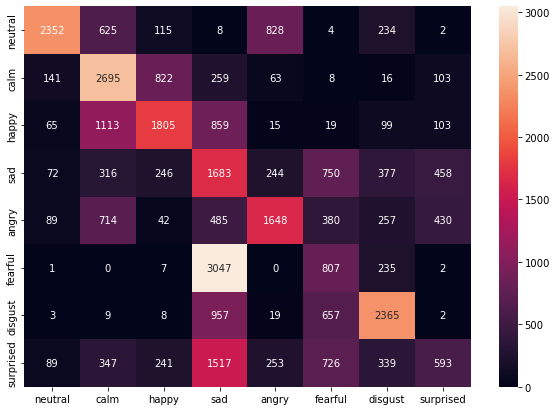

In [30]:
y_true, y_pred = U.au_recon_and_classiffication_accuracy(model, num_samples=2048)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)